# Quick introduction

## Reading and plotting

In [1]:
import io
import requests
from pathlib import Path


def download_demo_file(url):
    if not Path("CTD-spiked-unfiltered.cnv.bz2").exists():
        response = requests.get(url, allow_redirects=True)
        try:
            response.raise_for_status()
        except requests.exceptions.HTTPError as err:
            raise requests.exceptions.HTTPError(f"{response.content.decode()}") from err
        data = io.BytesIO(response.content)
        data.seek(0)
        Path("CTD-spiked-unfiltered.cnv.bz2").write_bytes(data.read())


url = "https://github.com/pyoceans/python-ctd/raw/main/tests/data/CTD-spiked-unfiltered.cnv.bz2"

# download_demo_file(url)

In [2]:
import ctd


# cast = ctd.from_cnv("CTD-spiked-unfiltered.cnv.bz2")

# cast = ctd.from_cnv("/home/mayorga/dinosip-python-cnvs/cruises_cnvs_2023/20230628P28C01.cnv")
cast = ctd.from_cnv("/home/mayorga/dinosip-python-cnvs/cruises_cnvs_2024/20240718_CTD05_p28.cnv")

down, up = cast.split()

down.head()

,t090C,sal00,c0S/m,sbox0Mm/Kg,CStarTr0,flECO-AFL,ph,par,flag
Pressure [dbar],,,,,,,,,
6.543,14.0140,30.7695,3.737626,225.061,68.6557,6.8175,8.034,137.86,False
6.558,14.0138,30.7709,3.737760,224.907,68.9782,6.8175,8.029,137.86,False
6.543,14.0135,30.7719,3.737836,224.743,69.0319,6.8175,8.034,138.65,False
6.558,14.0134,30.7718,3.737811,224.720,69.0050,6.8175,8.034,139.04,False
6.543,14.0128,30.7725,3.737842,224.852,68.9782,6.8175,8.029,139.04,False


It is a `pandas.DataFrame` with all the pandas methods and properties.

In [3]:
type(cast)

pandas.core.frame.DataFrame

But with extras for pre-processing and plotting a ocean vertical profiles.

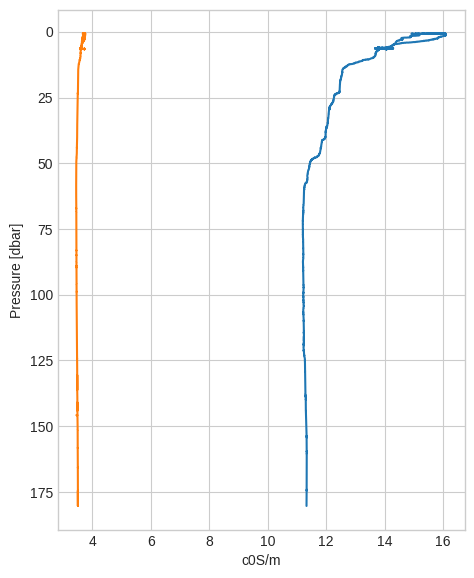

In [4]:
from matplotlib import style


style.use("seaborn-v0_8-whitegrid")

down["t090C"].plot_cast()
down["c0S/m"].plot_cast();

Sometimes it is useful to plot the second variable in a different axis so we can compare the two.

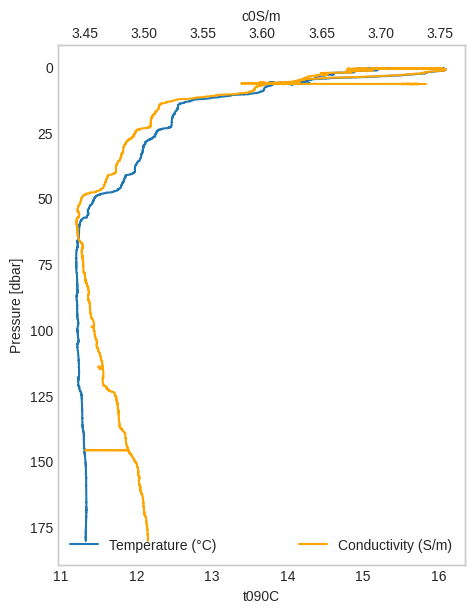

In [5]:
ax0 = down["t090C"].plot_cast(label="Temperature (°C)")
ax1 = down["c0S/m"].plot_cast(
    ax=ax0,
    label="Conductivity (S/m)",
    color="orange",
    secondary_y=True,
)


ax0.grid(False)
ax1.grid(False)

ax0.legend(loc="lower left")
ax1.legend(loc="lower right");

`python-ctd` saves of the file metadata in a dictionary to make them easy to access later. 

In [6]:
metadata = cast._metadata

metadata.keys()

dict_keys(['name', 'header', 'config', 'names', 'skiprows', 'time', 'lon', 'lat'])

In [7]:
metadata['lat'], metadata['lon']

(47.71333333333333, -122.41933333333333)

In [8]:
print(metadata["header"])

* Sea-Bird SBE 9 Data File:
* FileName = C:\Data\RC0122ctd\20240718_CTD05_p28.hex
* Software Version Seasave V 7.26.7.107
* Temperature SN = 1121
* Conductivity SN = 2881
* Number of Bytes Per Scan = 31
* Number of Voltage Words = 4
* Number of Scans Averaged by the Deck Unit = 1
* System UpLoad Time = Jul 18 2024 08:54:01
* NMEA Latitude = 47 42.80 N
* NMEA Longitude = 122 25.16 W
* NMEA UTC (Time) = Jul 18 2024  15:54:00
* Store Lat/Lon Data = Append to Every Scan
* SBE 11plus V 5.2
* number of scans to average = 1
* pressure baud rate = 9600
* NMEA baud rate = 4800
* GPIB address = 1
* advance primary conductivity  0.073 seconds
* advance secondary conductivity  0.073 seconds
* delete word 3 from scan
* delete word 4 from scan
* autorun on power up is disabled
* S>
** Ship: R/V Rachel Carson
** Cruise ID: RC0121
** Tech: Jalickee
** Chief Scientist: Boyar
** Station: p28
** Cast:  05
* System UTC = Jul 18 2024 15:54:01
*END*


## Pre-processing steps

Usually the first pre-processing step is to filter the high frequency jitter in the pressure sensor with a low pass filter, here is a zoom in the pressure data (the `pandas` index) demonstrating it:

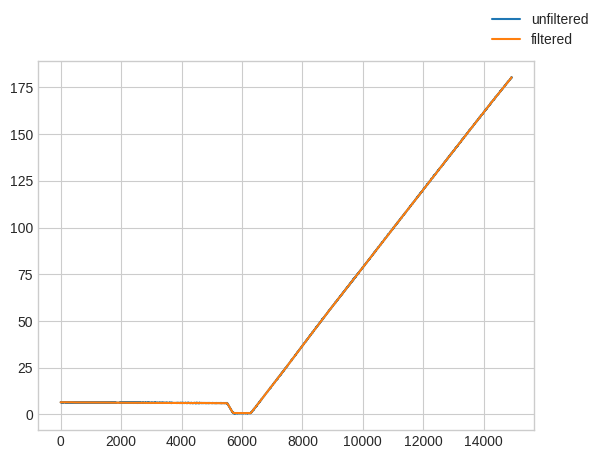

In [9]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(down.index, label="unfiltered")
ax.plot(down.lp_filter().index, label="filtered")
# ax.axis([20870, 20930, 557.5, 559])
# ax.axis([20870, 20930, 557.5, 559])
fig.legend();

Thanks to [pandas_flavor](https://github.com/Zsailer/pandas_flavor) we can chain all the pre-processing steps together.

In [10]:
down = down[["t090C", "c0S/m"]]

proc = (
    down.remove_above_water()
    .remove_up_to(idx=7)
    .despike(n1=2, n2=20, block=100)
    .lp_filter()
    .press_check()
    .interpolate()
    .bindata(delta=1, method="interpolate")
    .smooth(window_len=21, window="hanning")
)

proc.head()

,t090C,c0S/m
8.0,13.784330,3.600170
9.0,13.606445,3.587466
10.0,13.431428,3.574971
11.0,13.264619,3.563063
12.0,13.110621,3.552074


## CTD derive

Now we can compute all the derived variables.

In [11]:
lon, lat = metadata["lon"], metadata["lat"]
lon, lat

(-122.41933333333333, 47.71333333333333)

In [12]:
import gsw


p = proc.index

SP = gsw.SP_from_C(proc["c0S/m"].to_numpy() * 10.0, proc["t090C"].to_numpy(), p)
SA = gsw.SA_from_SP(SP, p, lon, lat)
SR = gsw.SR_from_SP(SP)

CT = gsw.CT_from_t(SA, proc["t090C"].to_numpy(), p)
z = -gsw.z_from_p(p, lat)
sigma0_CT = gsw.sigma0(SA, CT)

proc = (
    proc.assign(SP=SP)
    .assign(SA=SA)
    .assign(SR=SR)
    .assign(CT=CT)
    .assign(z=z)
    .assign(sigma0_CT=sigma0_CT)
)

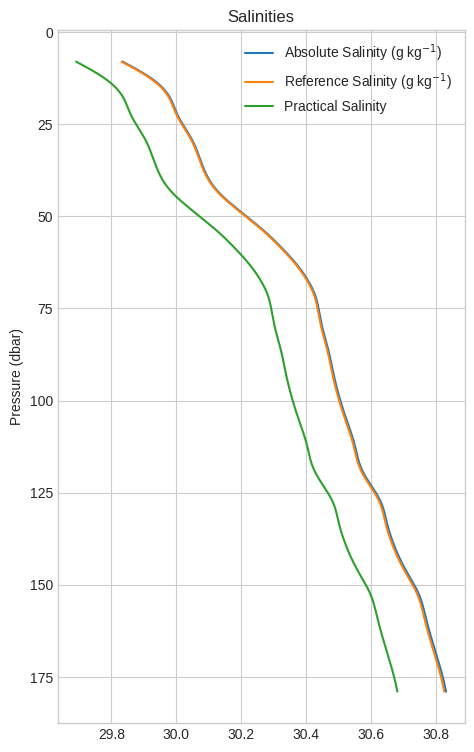

In [13]:
labels = [
    r"Absolute Salinity (g kg$^{-1}$)",
    r"Reference Salinity (g kg$^{-1}$)",
    "Practical Salinity",
]


ax = proc[["SA", "SR", "SP"]].plot_cast(
    figsize=(5.25, 9),
    label=labels,
)
ax.set_ylabel("Pressure (dbar)")
ax.grid(True)
ax.legend()
ax.set_title("Salinities");

Last but not least let's tweak a three line plot with the main variables measured.

In [14]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

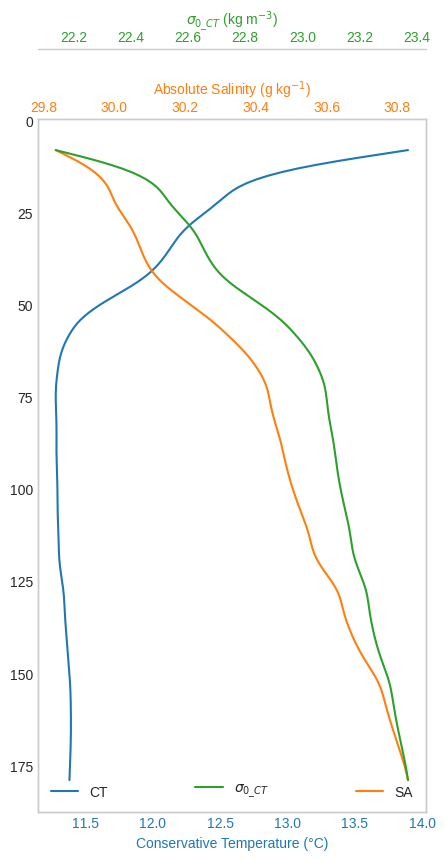

In [15]:
fig, ax0 = plt.subplots(figsize=(5, 9))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

ax0.invert_yaxis()
ax1 = ax0.twiny()
ax2 = ax0.twiny()

(l0,) = ax0.plot(proc["CT"], proc.index, color=colors[0], label="CT")
ax0.set_xlabel("Conservative Temperature (°C)")

(l1,) = ax1.plot(proc["SA"], proc.index, color=colors[1], label="SA")
ax1.set_xlabel("Absolute Salinity (g kg$^{-1}$)")

(l2,) = ax2.plot(
    proc["sigma0_CT"], proc.index, color=colors[2], label=r"$\sigma_{0\_CT}$"
)
ax2.set_xlabel(r"$\sigma_{0\_CT}$ (kg m$^{-3}$)")

make_patch_spines_invisible(ax2)
ax2.spines["top"].set_position(("axes", 1.1))
ax2.spines["top"].set_visible(True)

ax0.xaxis.label.set_color(l0.get_color())
ax1.xaxis.label.set_color(l1.get_color())
ax2.xaxis.label.set_color(l2.get_color())

ax0.tick_params(axis="x", colors=l0.get_color())
ax1.tick_params(axis="x", colors=l1.get_color())
ax2.tick_params(axis="x", colors=l2.get_color())

ax0.grid(False)
ax1.grid(False)
ax2.grid(False)

ax0.legend(loc="lower left")
ax1.legend(loc="lower right")
ax2.legend(loc="lower center");